# Segmentation

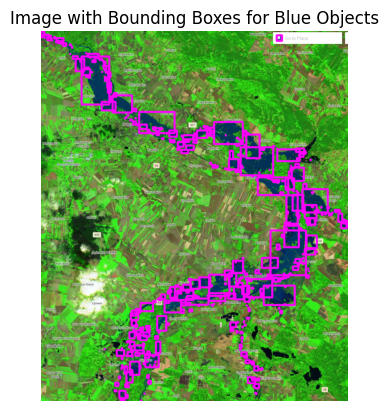

In [33]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# Function to segment only blue objects in the image
def segment_blue_objects(image_path):
    # Load the image in color (BGR format)
    image = cv2.imread(image_path)

    # Convert the image from BGR to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range of blue color in HSV space
    lower_blue = np.array([100, 150, 50])   # Lower bound of blue in HSV
    upper_blue = np.array([140, 255, 255])  # Upper bound of blue in HSV

    # Create a mask that only keeps blue areas of the image
    blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

    # Apply the mask to the original image
    blue_objects = cv2.bitwise_and(image, image, mask=blue_mask)

    return image, blue_objects, blue_mask

# Function to find bounding boxes for the blue objects
def find_bounding_boxes(mask):
    # Find contours in the blue mask image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bounding_boxes = []
    for contour in contours:
        # Get the bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, x + w, y + h))  # (x_min, y_min, x_max, y_max)

    return bounding_boxes

# Function to draw bounding boxes on the image
def draw_bounding_boxes(image, bounding_boxes):
    image = copy.deepcopy(image)
    # Draw bounding boxes on the image
    for bbox in bounding_boxes:
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 255), 5)  # Green box

    # Convert the image from BGR to RGB for visualization
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes
    plt.imshow(image_rgb)
    plt.title("Image with Bounding Boxes for Blue Objects")
    plt.axis('off')
    plt.show()


img1, blue_objects, blue_mask = segment_blue_objects("lewin.jpg")
bounding_boxes1 = find_bounding_boxes(blue_mask)
draw_bounding_boxes(img1, bounding_boxes1)

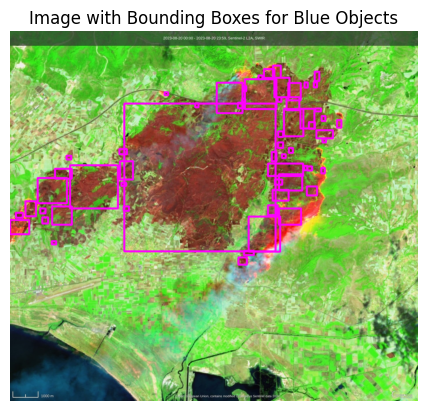

In [34]:
# Function to segment only red objects in the image
def segment_red_objects(image_path):
    # Load the image in color (BGR format)
    image = cv2.imread(image_path)

    # Convert the image from BGR to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range of red color in HSV space
    # Red color has two ranges in HSV: one for lower reds and one for upper reds
    lower_red1 = np.array([0, 80, 30])    # Lower bound of red in HSV (0° to 10° hue range)
    upper_red1 = np.array([10, 255, 180]) # Upper bound of red in HSV (0° to 10° hue range)

    lower_red2 = np.array([170, 80, 30])  # Lower bound of red in HSV (170° to 180° hue range)
    upper_red2 = np.array([180, 255, 180]) # Upper bound of red in HSV (170° to 180° hue range)

    # Create a mask that keeps red areas of the image
    mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)

    # Combine the two masks to capture all reds
    red_mask = cv2.bitwise_or(mask1, mask2)

    # Apply the mask to the original image
    red_objects = cv2.bitwise_and(image, image, mask=red_mask)

    return image, red_objects, red_mask


img2, red_objects, red_mask = segment_red_objects("before.jpg")
bounding_boxes2 = find_bounding_boxes(red_mask)
draw_bounding_boxes(img2, filter_bboxes(bounding_boxes2))

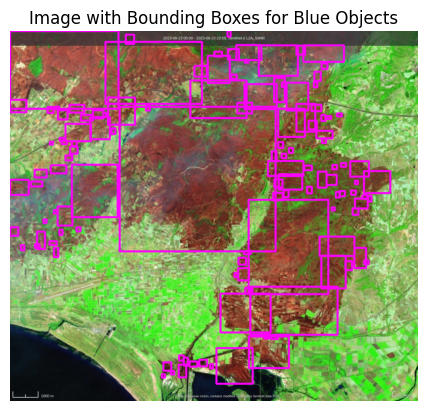

In [35]:
img2, red_objects, red_mask = segment_red_objects("after.jpg")
bounding_boxes2 = find_bounding_boxes(red_mask)
draw_bounding_boxes(img2, filter_bboxes(bounding_boxes2))

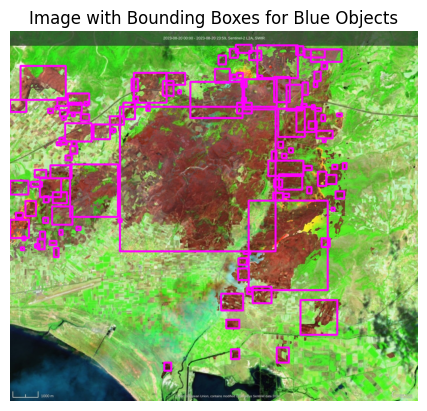

In [36]:
img2, red_objects, red_mask = segment_red_objects("middle.jpg")
bounding_boxes2 = find_bounding_boxes(red_mask)
draw_bounding_boxes(img2, filter_bboxes(bounding_boxes2))

# Filter bounding boxes

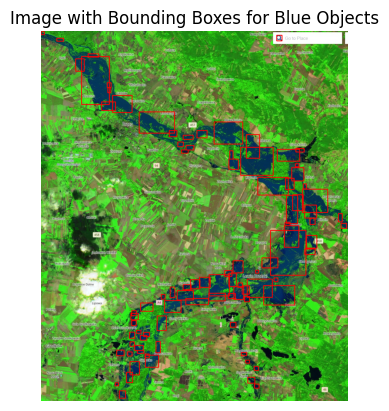

In [6]:
def filter_bboxes(bboxes, min_size=10):
    """
    Filter bounding boxes by removing those that are inside another box
    and removing boxes smaller than min_size (10 pixels by default).

    Parameters:
    - bboxes: List of bounding boxes in the form [(x_min, y_min, x_max, y_max), ...]
    - min_size: Minimum size (width and height) for a bounding box to be kept.

    Returns:
    - filtered_bboxes: List of filtered bounding boxes.
    """

    def is_inside(box1, box2):
        """ Check if box1 is inside box2 """
        x1_min, y1_min, x1_max, y1_max = box1
        x2_min, y2_min, x2_max, y2_max = box2

        return (x1_min >= x2_min and x1_max <= x2_max and
                y1_min >= y2_min and y1_max <= y2_max)

    def is_small(box, min_size):
        """ Check if a box is smaller than the minimum size """
        x_min, y_min, x_max, y_max = box
        return (x_max - x_min < min_size) or (y_max - y_min < min_size)

    # Remove boxes smaller than min_size
    filtered_bboxes = [box for box in bboxes if not is_small(box, min_size)]

    # Remove boxes that are inside other boxes
    final_bboxes = []
    for i, box in enumerate(filtered_bboxes):
        inside_any = False
        for j, other_box in enumerate(filtered_bboxes):
            if i != j and is_inside(box, other_box):
                inside_any = True
                break
        if not inside_any:
            final_bboxes.append(box)

    return final_bboxes

bounding_boxes1f = filter_bboxes(bounding_boxes1)
draw_bounding_boxes(img1, bounding_boxes1f)

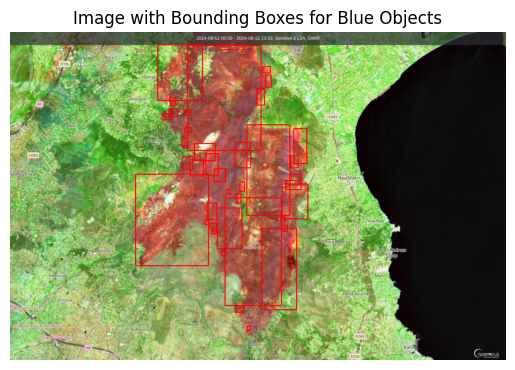

In [ ]:
bounding_boxes2f = filter_bboxes(bounding_boxes2)
draw_bounding_boxes(img2, bounding_boxes2f)

# Coords mapping

In [7]:
COORDS =  [17.497787, 50.694065, 17.729874, 50.794868]

In [12]:
def pixel_to_geo_coords(image, bbox_pixels, geo_bbox):
    """
    Convert pixel bounding box to geographic coordinates.

    Parameters:
    - bbox_pixels: Tuple (x_min, y_min, x_max, y_max) in pixel coordinates
    - image_size: Tuple (image_width, image_height)
    - geo_bbox: Tuple (lon_min, lat_min, lon_max, lat_max) representing the geographic bounding box of the image

    Returns:
    - geo_bbox_converted: Geographic bounding box (lon_min, lat_min, lon_max, lat_max)
    """
    x_min, y_min, x_max, y_max = bbox_pixels
    image_width, image_height, _ = image.shape
    lon_min, lat_min, lon_max, lat_max = geo_bbox

    image_height, image_width, _ = image.shape

    # Calculate geographic coordinates for each pixel coordinate
    geo_x_min = lon_min + (x_min / image_width) * (lon_max - lon_min)
    geo_x_max = lon_min + (x_max / image_width) * (lon_max - lon_min)

    geo_y_min = lat_max - (y_max / image_height) * (lat_max - lat_min)  # lat_min at bottom
    geo_y_max = lat_max - (y_min / image_height) * (lat_max - lat_min)  # lat_max at top

    return [geo_x_min, geo_y_min, geo_x_max, geo_y_max]


def convert_danger_zones_to_coords(image, bbox, real_coords):
  return [pixel_to_geo_coords(image, box, real_coords) for box in bbox]


bounding_boxes1_coords = convert_danger_zones_to_coords(img1, bounding_boxes1f, COORDS)
#bounding_boxes2_coords = convert_danger_zones_to_coords(img2, bounding_boxes2, COORDS)

In [14]:
bounding_boxes1_coords

[[17.556924552884613, 50.69486821115538, 17.561610925, 50.696876239043824],
 [17.659132097115382,
  50.69759912908367,
  17.66247950576923,
  50.698723624701195],
 [17.55380030480769, 50.69824169800797, 17.556255071153846, 50.69904490916335],
 [17.653999403846154,
  50.69896458804781,
  17.659355257692308,
  50.700571010358566],
 [17.562280406730768, 50.69912523027889, 17.56696677884615, 50.70193646932271],
 [17.65890893653846, 50.702418396015936, 17.66203318461538, 50.70354289163347],
 [17.564958333653845,
  50.70121357928287,
  17.572099472115383,
  50.70482802948207],
 [17.652437279807693,
  50.70442642390439,
  17.655338367307692,
  50.705229635059766],
 [17.576562683653844,
  50.703301928286855,
  17.586604909615385,
  50.7065950940239],
 [17.57633952307692,
  50.705872203984065,
  17.579463771153844,
  50.706916378486056],
 [17.649089871153844, 50.70643445179283, 17.65310676153846, 50.70731798406375],
 [17.56317304903846, 50.70635413067729, 17.566520457692306, 50.70747862629482],